In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv ("household_power_consumption.txt", sep=";",
                    header=0, low_memory=False, infer_datetime_format=True, 
                    parse_dates={"datetime":[0,1]},index_col=["datetime"])

In [3]:
df.isna().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [4]:
import pandas_profiling as pp

In [5]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df)
prof

In [4]:
count_na = 0
for values in df.values.tolist():
    for value in values:
        if value == '?':
            count_na += 1
        else:
            continue
            
print(count_na)

155874


In [5]:
df.replace("?", np.nan, inplace = True)

df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [6]:
for column in df.select_dtypes(include=['object']).columns:
    df[[column]] = df[[column]].astype('float')

In [7]:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [9]:
df_new = df.copy()
df_new['active_energy_consumed'] = df_new.apply(lambda row: row.Global_active_power  * 1000/60 - row.Sub_metering_1 
                                        - row.Sub_metering_2 - row.Sub_metering_3, axis=1)
df_new.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,active_energy_consumed
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667


In [8]:
#daily rDownsample 
df_daily = df.resample('D').sum()
df_daily.head(3)
df_daily.isna().sum()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


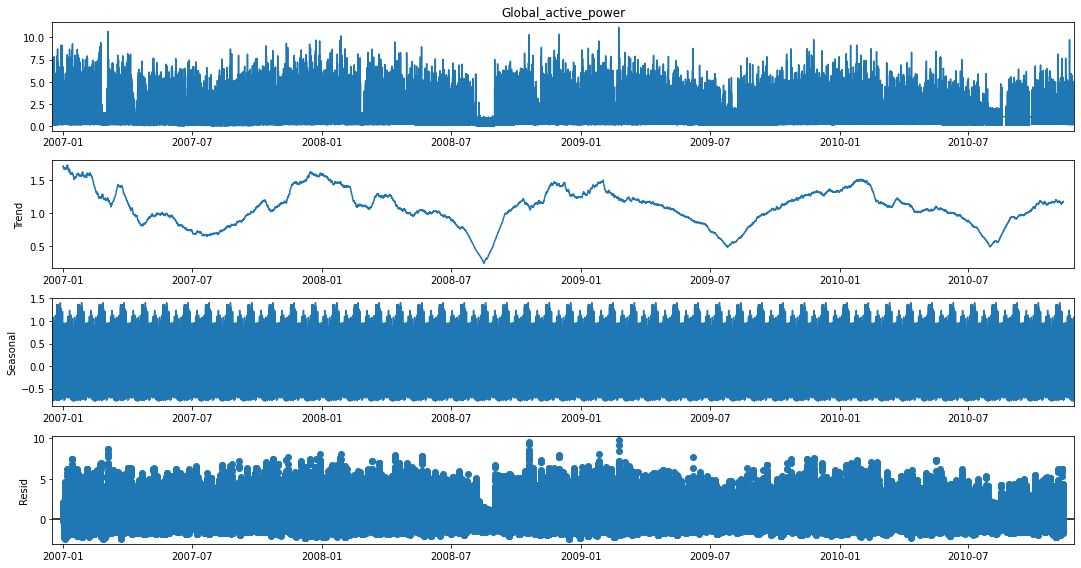

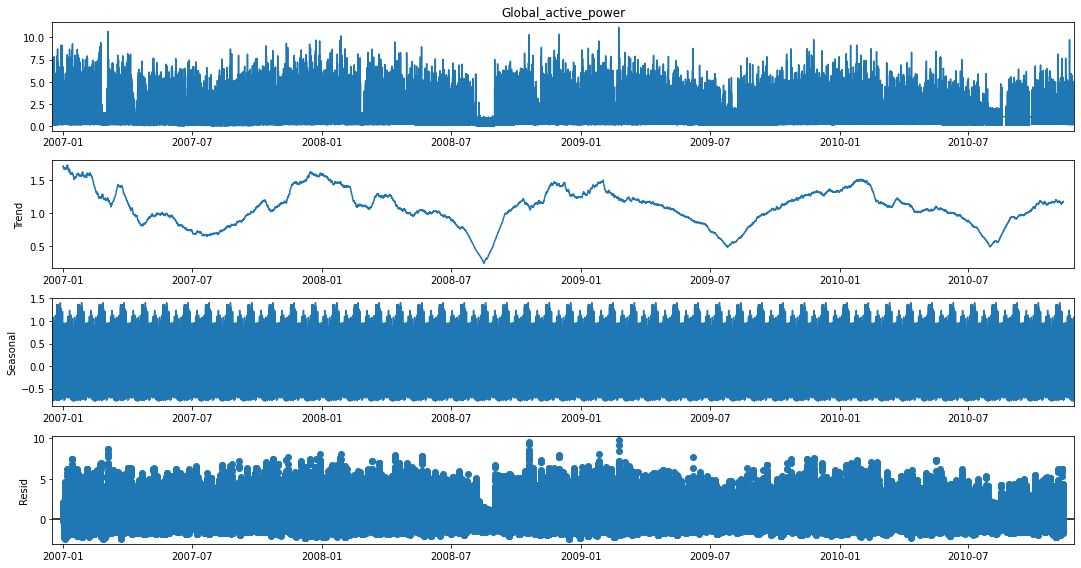

In [9]:
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 15, 8

#60 mins, 24 hrs, 30 days = 43200
decompose_series = sm.tsa.seasonal_decompose(df['Global_active_power'], freq = 43200, model='additive')
decompose_series.plot()
plt.show()

In [49]:
dff = df_daily.reset_index()
from scipy.stats import pearsonr

corr, p = pearsonr(dff['Global_active_power'], dff['Global_reactive_power'])
round(corr, 2)

0.04

In [50]:
corr, p = pearsonr(dff['Voltage'], dff['Global_intensity'])
round(corr, 2)

0.05

In [12]:
dataset = dff[['datetime', 'Global_active_power']]
dataset = dataset.rename(columns={'datetime': 'ds',
                        'Global_active_power': 'y'})

dataset.head(3)

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826


No handles with labels found to put in legend.


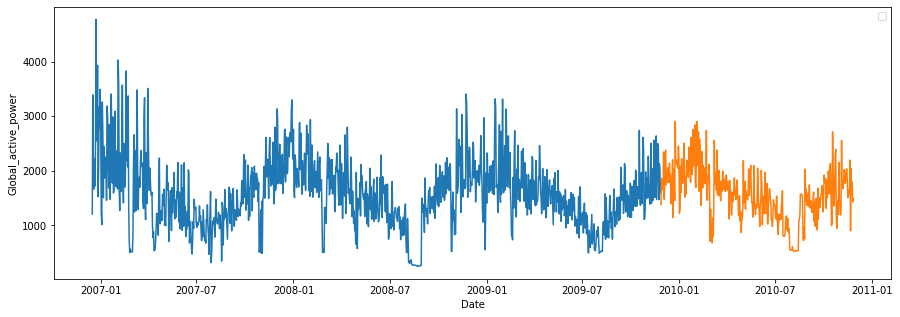

In [13]:
n_tests = 365
df_train = dataset[:-n_tests]
df_test = dataset[-n_tests:]

# visualize
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_train['ds'], df_train['y'])
ax.plot(df_test['ds'], df_test['y'])
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Global_active_power');

In [14]:
from fbprophet import Prophet

model = Prophet(weekly_seasonality=True, daily_seasonality=True)
model.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
C:\Users\user\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [15]:
forecast = model.predict(df_test)
forecast.head(3)
forecast.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1230.052388,1521.669110,2657.832481,1230.052388,1230.052388,870.023701,870.023701,870.023701,351.561427,...,-64.129679,-64.129679,-64.129679,582.591953,582.591953,582.591953,0.0,0.0,0.0,2100.076089
1,2009-11-28,1230.178174,1862.264619,2949.281573,1230.178174,1230.178174,1173.245091,1173.245091,1173.245091,351.561427,...,245.830409,245.830409,245.830409,575.853255,575.853255,575.853255,0.0,0.0,0.0,2403.423265
2,2009-11-29,1230.303960,1840.319605,2934.823565,1230.303960,1230.303960,1147.233437,1147.233437,1147.233437,351.561427,...,228.532232,228.532232,228.532232,567.139778,567.139778,567.139778,0.0,0.0,0.0,2377.537397


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
362,2010-11-24,1275.586919,1627.121156,2780.854682,1263.874264,1287.314068,912.340441,912.340441,912.340441,351.561427,...,-24.714627,-24.714627,-24.714627,585.493640,585.493640,585.493640,0.0,0.0,0.0,2187.927360
363,2010-11-25,1275.712705,1518.204885,2587.947271,1263.953584,1287.468281,744.835221,744.835221,744.835221,351.561427,...,-194.892616,-194.892616,-194.892616,588.166410,588.166410,588.166410,0.0,0.0,0.0,2020.547927
364,2010-11-26,1275.838491,1617.213944,2725.559136,1264.035480,1287.643276,874.955069,874.955069,874.955069,351.561427,...,-64.129679,-64.129679,-64.129679,587.523321,587.523321,587.523321,0.0,0.0,0.0,2150.793560


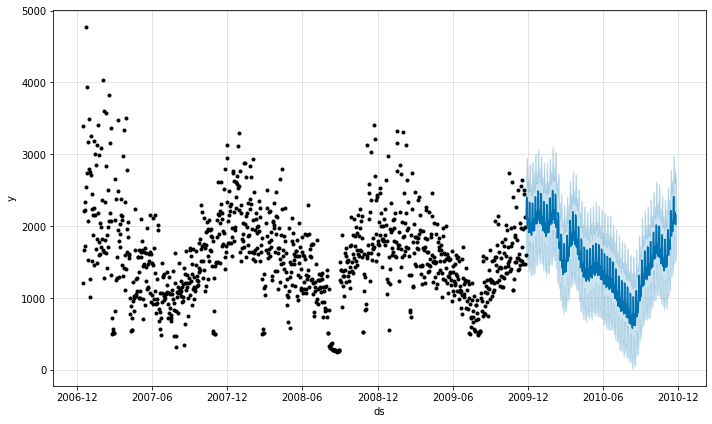

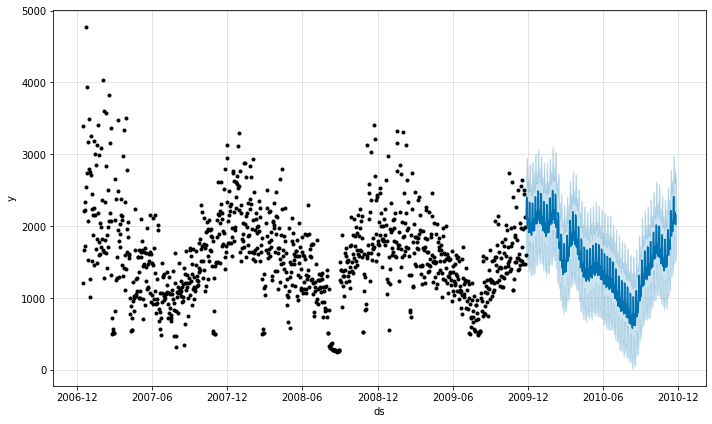

In [16]:
model.plot(forecast)

In [37]:
y_true = np.array(df_test['y'])
y_forecast = np.array(forecast['yhat'])
mape = np.mean(np.abs((y_true - y_forecast) / y_true)) * 100
round(mape, 2)

20.84

In [38]:
import ml_metrics as metrics
metric_df = forecast.set_index('ds')[['yhat']].join(df_test.set_index('ds').y).reset_index()
rmse_v1 = metrics.rmse(metric_df.y, metric_df.yhat)
round (rmse_v1, 2)

374.77

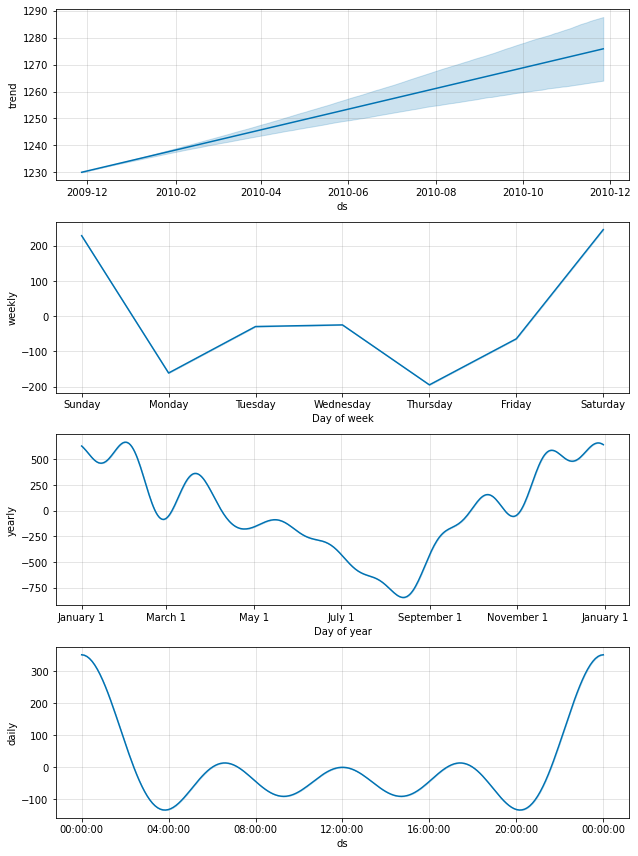

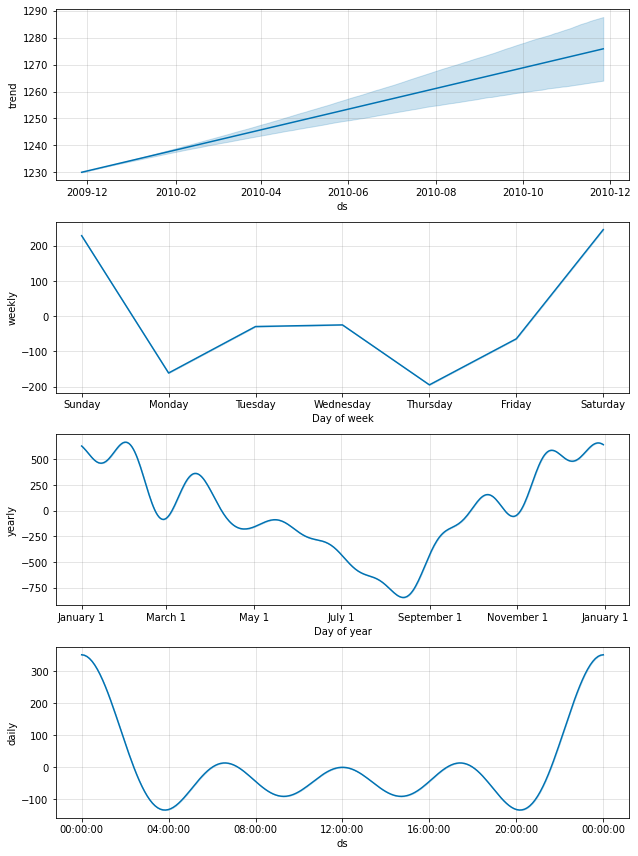

In [21]:
model.plot_components(forecast)

In [39]:
dataset['add1'] = dff['Global_reactive_power']
dataset['add2'] = dff['Voltage']
dataset['add3'] = dff['Global_intensity']
dataset['add4'] = dff['Sub_metering_1']
dataset['add5'] = dff['Sub_metering_2']
dataset['add6'] = dff['Sub_metering_3']

In [40]:
n_tests = 365
df_trainn = dataset[:-n_tests]
df_testt = dataset[-n_tests:]

In [41]:
new_model = Prophet(weekly_seasonality=True, daily_seasonality=True)
new_model.add_regressor('add1')
new_model.add_regressor('add2')
new_model.add_regressor('add3')
new_model.add_regressor('add4')
new_model.add_regressor('add5')
new_model.add_regressor('add6')
new_model.fit(df_trainn);

C:\Users\user\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [42]:
forecast2 = new_model.predict(df_testt)

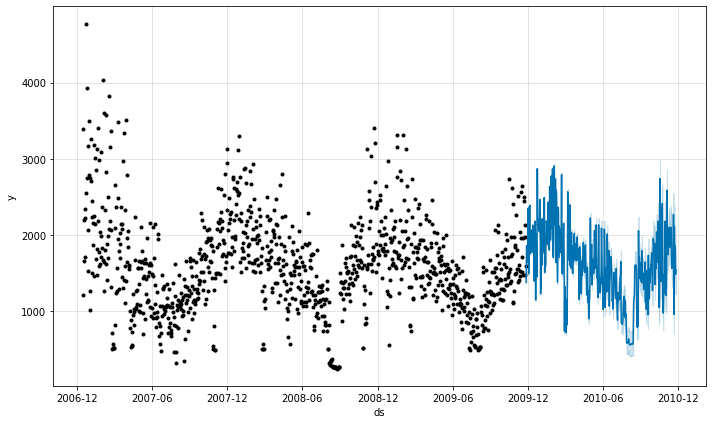

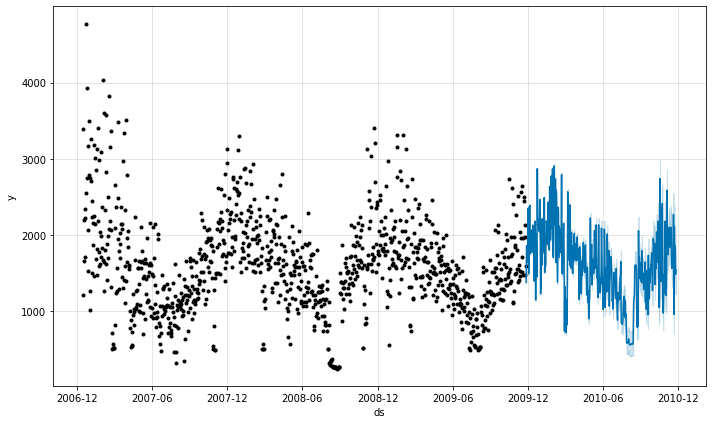

In [43]:
new_model.plot(forecast2)

In [44]:
metric_dff = forecast2.set_index('ds')[['yhat']].join(df_testt.set_index('ds').y).reset_index()

x1 = metric_dff.y
y1 = metric_dff.yhat

def mape (x1, y1):
    x1, y1 = np.array(x1), np.array(y1)
    return np.mean(np.abs((x1 - y1) / y1)) *100

mape = mape(x1, y1)
round (mape, 2)

2.4

In [45]:
rmse_v2 = metrics.rmse(metric_dff.y, metric_dff.yhat)
round (rmse_v2, 2)

37.32

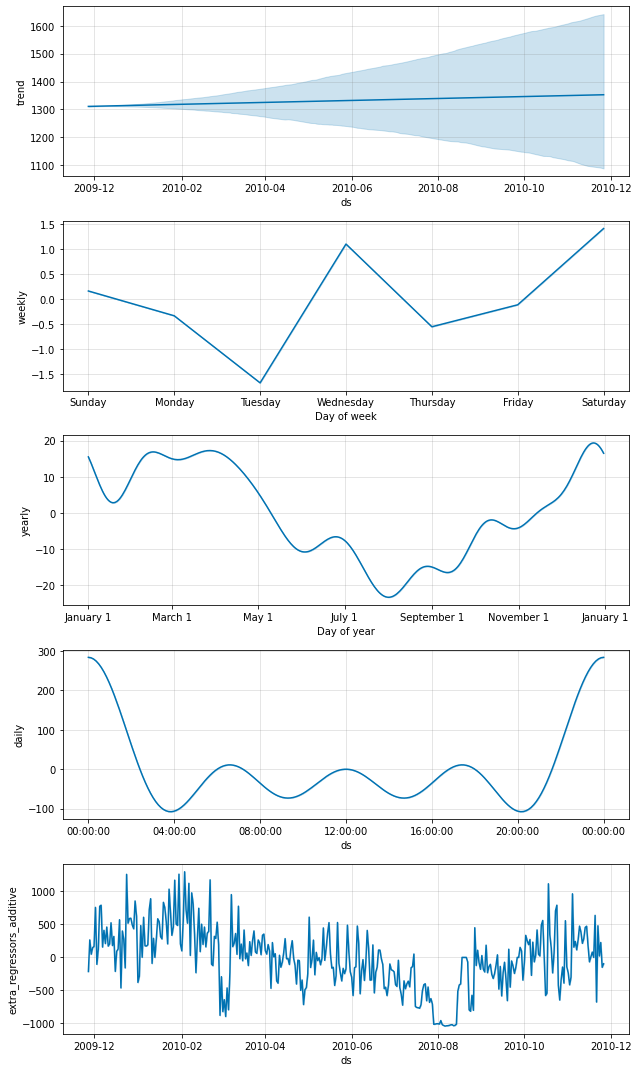

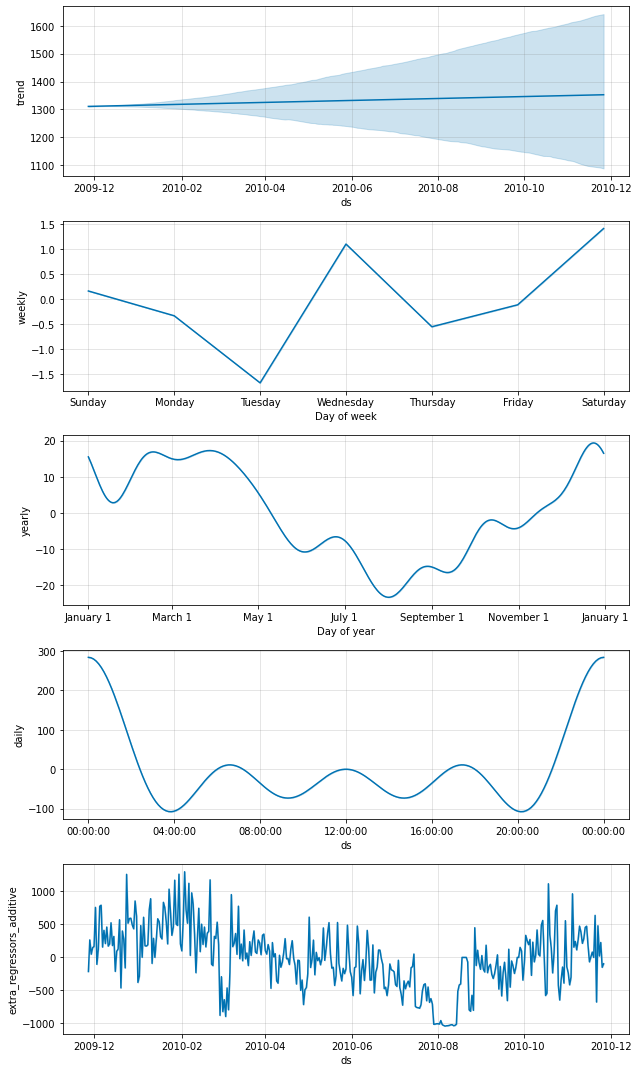

In [48]:
new_model.plot_components(forecast2)